# Exploring the SVHN Data

### Importing neccessary libraries

In [1]:

import numpy as np
import scipy.io as sio

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torchinfo import summary

### Loading the test and training data

In [2]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [3]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

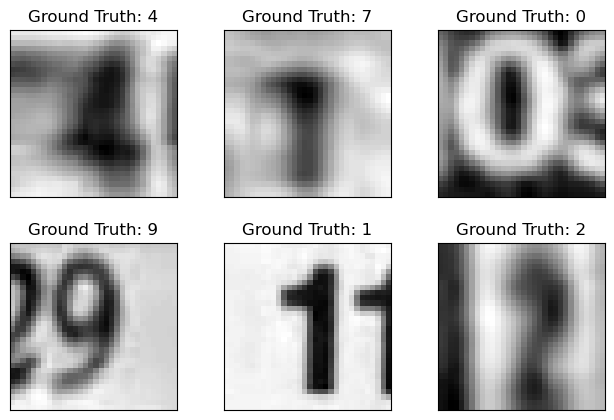

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [5]:
# 3 layer Net (1 convolutional layer, 2 linear layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1960, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv1(x)), 2))
        x = x.view(-1, 1960)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [16]:
# 4 layer Net (2 convolutional layers, 2 linear layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [25]:
# 5 layer Net (3 convolutional layers, 2 linear layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(270, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv2_drop(self.conv3(x)), 2)  # can't pool because image will be too small
        x = x.view(-1, 270)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [26]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


summary(network,(1000, 3, 32, 32))

C:\Users\magma\AppData\Local\Temp\ipykernel_19388\576835742.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1000, 10]                --
├─Conv2d: 1-1                            [1000, 10, 28, 28]        760
├─Conv2d: 1-2                            [1000, 20, 10, 10]        5,020
├─Conv2d: 1-3                            [1000, 30, 3, 3]          5,430
├─Dropout2d: 1-4                         [1000, 30, 3, 3]          --
├─Linear: 1-5                            [1000, 50]                13,550
├─Linear: 1-6                            [1000, 10]                510
Total params: 25,270
Trainable params: 25,270
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.16
Input size (MB): 12.29
Forward/backward pass size (MB): 81.36
Params size (MB): 0.10
Estimated Total Size (MB): 93.75

In [27]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [28]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [29]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [65]:
print(example_data.shape)
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

torch.Size([1000, 3, 32, 32])


C:\Users\magma\AppData\Local\Temp\ipykernel_19388\576835742.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.5855, Accuracy: 21629/26032 (83%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 1.101319
Train Epoch: 1 [640/73257 (1%)]	Loss: 0.828743
Train Epoch: 1 [1280/73257 (2%)]	Loss: 0.906324
Train Epoch: 1 [1920/73257 (3%)]	Loss: 0.764363
Train Epoch: 1 [2560/73257 (3%)]	Loss: 0.761116
Train Epoch: 1 [3200/73257 (4%)]	Loss: 0.653912
Train Epoch: 1 [3840/73257 (5%)]	Loss: 0.804913
Train Epoch: 1 [4480/73257 (6%)]	Loss: 0.685385
Train Epoch: 1 [5120/73257 (7%)]	Loss: 0.795718
Train Epoch: 1 [5760/73257 (8%)]	Loss: 0.693893
Train Epoch: 1 [6400/73257 (9%)]	Loss: 0.924626
Train Epoch: 1 [7040/73257 (10%)]	Loss: 0.620425
Train Epoch: 1 [7680/73257 (10%)]	Loss: 0.706105
Train Epoch: 1 [8320/73257 (11%)]	Loss: 0.827085
Train Epoch: 1 [8960/73257 (12%)]	Loss: 0.732459
Train Epoch: 1 [9600/73257 (13%)]	Loss: 0.673096
Train Epoch: 1 [10240/73257 (14%)]	Loss: 0.696034
Train Epoch: 1 [10880/73257 (15%)]	Loss: 0.653051
Train Epoch: 1 [11520/73257 (16%)]	Loss: 0.669235
Train Epoch: 1 [12160/

Train Epoch: 2 [30720/73257 (42%)]	Loss: 0.790210
Train Epoch: 2 [31360/73257 (43%)]	Loss: 0.542227
Train Epoch: 2 [32000/73257 (44%)]	Loss: 0.692113
Train Epoch: 2 [32640/73257 (45%)]	Loss: 0.656659
Train Epoch: 2 [33280/73257 (45%)]	Loss: 0.765729
Train Epoch: 2 [33920/73257 (46%)]	Loss: 0.872462
Train Epoch: 2 [34560/73257 (47%)]	Loss: 0.871341
Train Epoch: 2 [35200/73257 (48%)]	Loss: 0.922947
Train Epoch: 2 [35840/73257 (49%)]	Loss: 0.705995
Train Epoch: 2 [36480/73257 (50%)]	Loss: 0.851475
Train Epoch: 2 [37120/73257 (51%)]	Loss: 0.894853
Train Epoch: 2 [37760/73257 (52%)]	Loss: 0.717355
Train Epoch: 2 [38400/73257 (52%)]	Loss: 0.808217
Train Epoch: 2 [39040/73257 (53%)]	Loss: 1.052402
Train Epoch: 2 [39680/73257 (54%)]	Loss: 0.596953
Train Epoch: 2 [40320/73257 (55%)]	Loss: 0.591739
Train Epoch: 2 [40960/73257 (56%)]	Loss: 0.680150
Train Epoch: 2 [41600/73257 (57%)]	Loss: 0.612456
Train Epoch: 2 [42240/73257 (58%)]	Loss: 0.645775
Train Epoch: 2 [42880/73257 (59%)]	Loss: 0.787856


Train Epoch: 3 [62720/73257 (86%)]	Loss: 0.347575
Train Epoch: 3 [63360/73257 (86%)]	Loss: 0.610664
Train Epoch: 3 [64000/73257 (87%)]	Loss: 0.570296
Train Epoch: 3 [64640/73257 (88%)]	Loss: 0.590623
Train Epoch: 3 [65280/73257 (89%)]	Loss: 0.539183
Train Epoch: 3 [65920/73257 (90%)]	Loss: 0.821554
Train Epoch: 3 [66560/73257 (91%)]	Loss: 0.418444
Train Epoch: 3 [67200/73257 (92%)]	Loss: 0.609677
Train Epoch: 3 [67840/73257 (93%)]	Loss: 0.667004
Train Epoch: 3 [68480/73257 (93%)]	Loss: 0.840478
Train Epoch: 3 [69120/73257 (94%)]	Loss: 0.690749
Train Epoch: 3 [69760/73257 (95%)]	Loss: 0.519213
Train Epoch: 3 [70400/73257 (96%)]	Loss: 0.772420
Train Epoch: 3 [71040/73257 (97%)]	Loss: 0.727694
Train Epoch: 3 [71680/73257 (98%)]	Loss: 0.819892
Train Epoch: 3 [72320/73257 (99%)]	Loss: 0.820357
Train Epoch: 3 [72960/73257 (100%)]	Loss: 0.768325

Test set: Avg. loss: 0.5362, Accuracy: 22074/26032 (85%)

Train Epoch: 4 [0/73257 (0%)]	Loss: 0.757722
Train Epoch: 4 [640/73257 (1%)]	Loss: 0.55740

Train Epoch: 5 [19840/73257 (27%)]	Loss: 0.658386
Train Epoch: 5 [20480/73257 (28%)]	Loss: 0.631441
Train Epoch: 5 [21120/73257 (29%)]	Loss: 0.643014
Train Epoch: 5 [21760/73257 (30%)]	Loss: 0.707038
Train Epoch: 5 [22400/73257 (31%)]	Loss: 0.493373
Train Epoch: 5 [23040/73257 (31%)]	Loss: 0.843901
Train Epoch: 5 [23680/73257 (32%)]	Loss: 0.530345
Train Epoch: 5 [24320/73257 (33%)]	Loss: 0.897777
Train Epoch: 5 [24960/73257 (34%)]	Loss: 0.699949
Train Epoch: 5 [25600/73257 (35%)]	Loss: 0.773952
Train Epoch: 5 [26240/73257 (36%)]	Loss: 0.518311
Train Epoch: 5 [26880/73257 (37%)]	Loss: 0.615738
Train Epoch: 5 [27520/73257 (38%)]	Loss: 0.450780
Train Epoch: 5 [28160/73257 (38%)]	Loss: 0.594424
Train Epoch: 5 [28800/73257 (39%)]	Loss: 0.774547
Train Epoch: 5 [29440/73257 (40%)]	Loss: 0.661344
Train Epoch: 5 [30080/73257 (41%)]	Loss: 0.608017
Train Epoch: 5 [30720/73257 (42%)]	Loss: 0.626597
Train Epoch: 5 [31360/73257 (43%)]	Loss: 0.542948
Train Epoch: 5 [32000/73257 (44%)]	Loss: 0.634498


Train Epoch: 6 [51840/73257 (71%)]	Loss: 0.724330
Train Epoch: 6 [52480/73257 (72%)]	Loss: 0.714655
Train Epoch: 6 [53120/73257 (72%)]	Loss: 0.714547
Train Epoch: 6 [53760/73257 (73%)]	Loss: 0.994975
Train Epoch: 6 [54400/73257 (74%)]	Loss: 0.614243
Train Epoch: 6 [55040/73257 (75%)]	Loss: 0.794395
Train Epoch: 6 [55680/73257 (76%)]	Loss: 0.698336
Train Epoch: 6 [56320/73257 (77%)]	Loss: 0.958359
Train Epoch: 6 [56960/73257 (78%)]	Loss: 0.738119
Train Epoch: 6 [57600/73257 (79%)]	Loss: 1.133359
Train Epoch: 6 [58240/73257 (79%)]	Loss: 0.566967
Train Epoch: 6 [58880/73257 (80%)]	Loss: 0.481391
Train Epoch: 6 [59520/73257 (81%)]	Loss: 0.771483
Train Epoch: 6 [60160/73257 (82%)]	Loss: 0.951004
Train Epoch: 6 [60800/73257 (83%)]	Loss: 0.707879
Train Epoch: 6 [61440/73257 (84%)]	Loss: 0.959918
Train Epoch: 6 [62080/73257 (85%)]	Loss: 0.686938
Train Epoch: 6 [62720/73257 (86%)]	Loss: 0.813376
Train Epoch: 6 [63360/73257 (86%)]	Loss: 0.648089
Train Epoch: 6 [64000/73257 (87%)]	Loss: 0.909783


Train Epoch: 8 [8960/73257 (12%)]	Loss: 0.647705
Train Epoch: 8 [9600/73257 (13%)]	Loss: 0.886682
Train Epoch: 8 [10240/73257 (14%)]	Loss: 0.674339
Train Epoch: 8 [10880/73257 (15%)]	Loss: 0.355181
Train Epoch: 8 [11520/73257 (16%)]	Loss: 0.757904
Train Epoch: 8 [12160/73257 (17%)]	Loss: 0.696519
Train Epoch: 8 [12800/73257 (17%)]	Loss: 0.664604
Train Epoch: 8 [13440/73257 (18%)]	Loss: 0.838930
Train Epoch: 8 [14080/73257 (19%)]	Loss: 0.569581
Train Epoch: 8 [14720/73257 (20%)]	Loss: 0.604960
Train Epoch: 8 [15360/73257 (21%)]	Loss: 0.701288
Train Epoch: 8 [16000/73257 (22%)]	Loss: 0.545620
Train Epoch: 8 [16640/73257 (23%)]	Loss: 0.549883
Train Epoch: 8 [17280/73257 (24%)]	Loss: 0.754402
Train Epoch: 8 [17920/73257 (24%)]	Loss: 0.680552
Train Epoch: 8 [18560/73257 (25%)]	Loss: 0.519354
Train Epoch: 8 [19200/73257 (26%)]	Loss: 0.699819
Train Epoch: 8 [19840/73257 (27%)]	Loss: 0.936014
Train Epoch: 8 [20480/73257 (28%)]	Loss: 0.774929
Train Epoch: 8 [21120/73257 (29%)]	Loss: 1.025293
Tr

Train Epoch: 9 [40320/73257 (55%)]	Loss: 1.163642
Train Epoch: 9 [40960/73257 (56%)]	Loss: 0.754114
Train Epoch: 9 [41600/73257 (57%)]	Loss: 0.688466
Train Epoch: 9 [42240/73257 (58%)]	Loss: 0.643413
Train Epoch: 9 [42880/73257 (59%)]	Loss: 0.608226
Train Epoch: 9 [43520/73257 (59%)]	Loss: 0.564824
Train Epoch: 9 [44160/73257 (60%)]	Loss: 0.598403
Train Epoch: 9 [44800/73257 (61%)]	Loss: 0.407801
Train Epoch: 9 [45440/73257 (62%)]	Loss: 0.894135
Train Epoch: 9 [46080/73257 (63%)]	Loss: 0.277319
Train Epoch: 9 [46720/73257 (64%)]	Loss: 0.836837
Train Epoch: 9 [47360/73257 (65%)]	Loss: 0.694739
Train Epoch: 9 [48000/73257 (66%)]	Loss: 0.685795
Train Epoch: 9 [48640/73257 (66%)]	Loss: 0.725212
Train Epoch: 9 [49280/73257 (67%)]	Loss: 0.367894
Train Epoch: 9 [49920/73257 (68%)]	Loss: 0.638157
Train Epoch: 9 [50560/73257 (69%)]	Loss: 0.466438
Train Epoch: 9 [51200/73257 (70%)]	Loss: 0.958220
Train Epoch: 9 [51840/73257 (71%)]	Loss: 0.812841
Train Epoch: 9 [52480/73257 (72%)]	Loss: 0.594042


Train Epoch: 10 [71040/73257 (97%)]	Loss: 0.777039
Train Epoch: 10 [71680/73257 (98%)]	Loss: 0.585222
Train Epoch: 10 [72320/73257 (99%)]	Loss: 0.476817
Train Epoch: 10 [72960/73257 (100%)]	Loss: 0.670340

Test set: Avg. loss: 0.4947, Accuracy: 22277/26032 (86%)



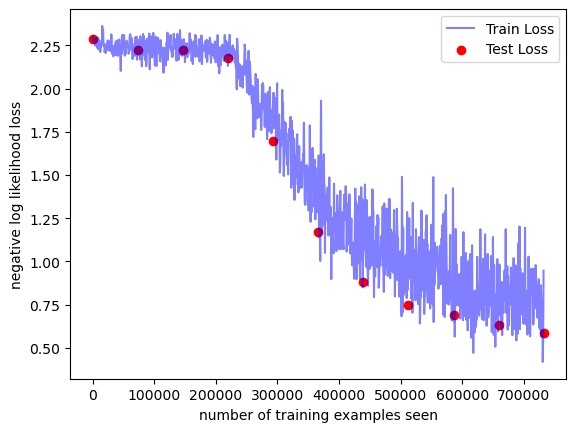

In [31]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', alpha = .5)
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [32]:
collection_test_losses.append(test_losses)

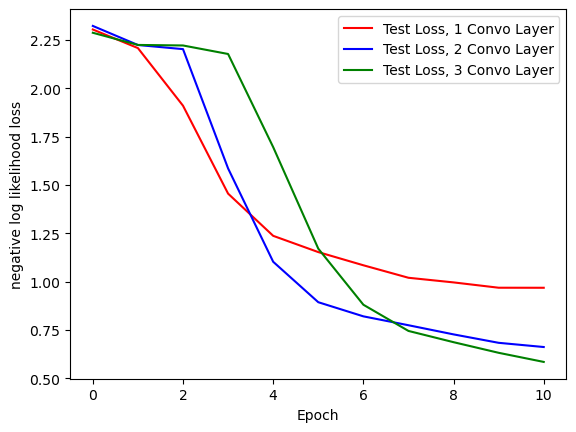

In [40]:
fig = plt.figure()

plt.plot(range(0,11), collection_test_losses[0], color='red')
plt.plot(range(0,11), collection_test_losses[1], color='blue')
plt.plot(range(0,11), collection_test_losses[2], color='green')

plt.legend(['Test Loss, 1 Convo Layer', 'Test Loss, 2 Convo Layer', 'Test Loss, 3 Convo Layer'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [13]:
with torch.no_grad():
  output = network(example_data)

/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_10407/235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_10407/2502561851.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


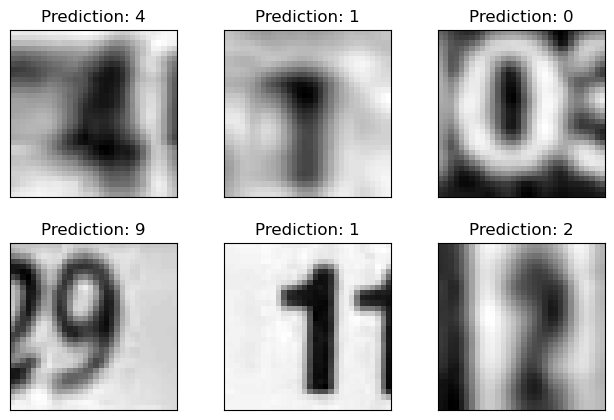

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

Text(0.5, 1.0, 'Accuracy of neural nets with different amounts of convolutional layers by epoch 10')

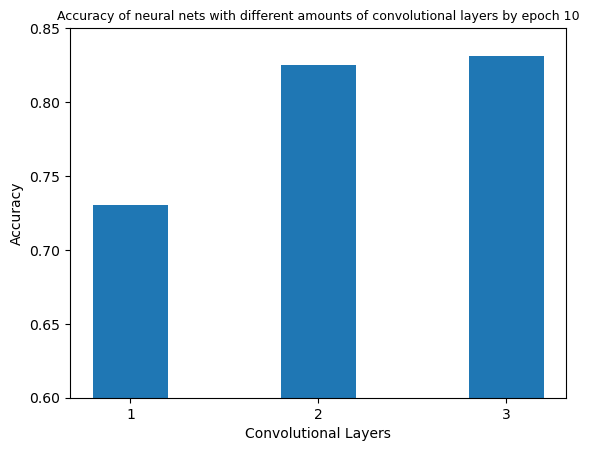

In [64]:
avg_loss = [0.9689,0.6625,0.5855]
accuracy = [19004/26032,21483/26032,21629/26032]

plt.ylim(.6,.85)
plt.bar(["1","2","3"],accuracy,width=.4)
plt.xlabel("Convolutional Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy of neural nets with different amounts of convolutional layers by epoch 10",size=9)